In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
from colossus.lss.mass_function import massFunction
from astropy.cosmology import WMAP9 as cosmo
import emcee

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

### Setup functions for emcee

In [3]:
def lnprior(k):
    M = k[0]
    z = k[1]
    if Mmin <= M <= Mmax and zmin <= z <= zmax:
        return 0.0
    return -np.inf

def dNdlnMdz(logM, z):
    dVdz = cosmo.differential_comoving_volume(z).value
    M = 10**logM
    dNdlnMdV = massFunction(M, z, mdef='500c', model='tinker08', q_out='dndlnM')*h**3
    dNdlnMdz = dNdlnMdV * dVdz
    return np.log(dNdlnMdz)

def lnprob(k):
    lp = lnprior(k)
    if not np.isfinite(lp):
        return -np.inf
    return lp + dNdlnMdz(k[0], k[1])

### My Metropolis-Hastings sampler

In [4]:
def my_mcmc(steps, burn_in, start_point):
    n = steps+burn_in
    
    x_cur = start_point
    x_next = np.random.uniform(low=[Mmin, zmin], high=[Mmax, zmax], size=(n,2))
    u = np.random.uniform(size=n)
    
    post_cur = dNdlnMdz(x_cur[0], x_cur[1])
    
    posterior = np.zeros((n, 2), dtype=np.ndarray)

    for ii in range(n):
        x_prop = x_next[ii]
        post_prop = dNdlnMdz(x_prop[0], x_prop[1])
        acceptance = min(post_prop/post_cur,1)
        if u[ii] <= acceptance:
            x_cur = x_prop
            post_cur = post_prop
        
        posterior[ii] = x_cur
    
    return posterior[burn_in:]

### Setup cosmology for massFunction & likelihood function

In [5]:
# set cosmology for mass function
cosmology.setCosmology('WMAP9')
# setup h for likelihood function and mass scaling
h = cosmo.H0.value/100

### Setup mass and redshift ranges for sample

In [6]:
Mmin = 13.5 - np.log10(h)
Mmax = 15.8 - np.log10(h)
zmin = 0.05
zmax = 1.0

### Generate array of starting points for emcee and run burn-in steps

In [7]:
# set 2 dimensions (M&z) and no. of walkers
ndim, nwalkers = 2, 10
# 2d array of starting points from full range of M&z
p0 = np.random.uniform(low=[Mmin, zmin], high=[Mmax, zmax], size=(nwalkers,2))
#run 100 steps to burn-in
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
pos, prob, state = sampler.run_mcmc(p0, 100)

### Run emcee sampler

In [8]:
# reset sampler to remove burn-in steps
sampler.reset()
# rerun sampler using burned in points as starting positions
pos, prob, state = sampler.run_mcmc(pos, 100_000)

In [9]:
# flatchain sampler for emcee cluster sample
clus_emcee = sampler.flatchain

### Run my MH sampler

In [13]:
clus_mymcmc = my_mcmc(100_000, 1000, [14.7, 0.5])

### emcee sample Mz plane
* emcee still struggles to probe low probability areas of parameter space: higher mass clusters in general and particularly low $z$, high mass clusters

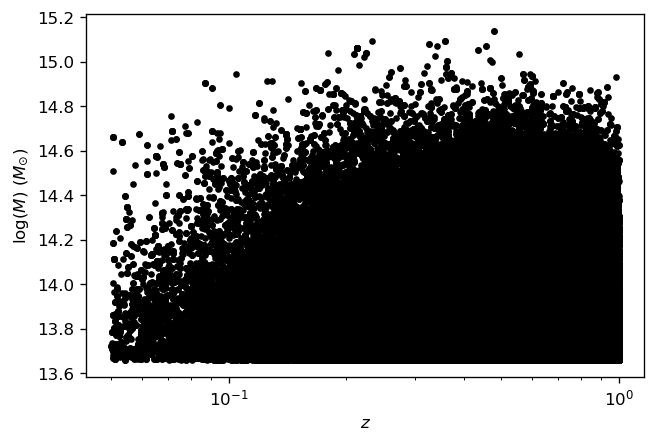

In [14]:
plt.scatter(clus_emcee.T[1], clus_emcee.T[0], marker='.', color='k')
plt.xlabel(r'$z$')
plt.ylabel(r'log($M$) ($M_{\odot}$)')
plt.xscale('log')

### MH sample Mz plane

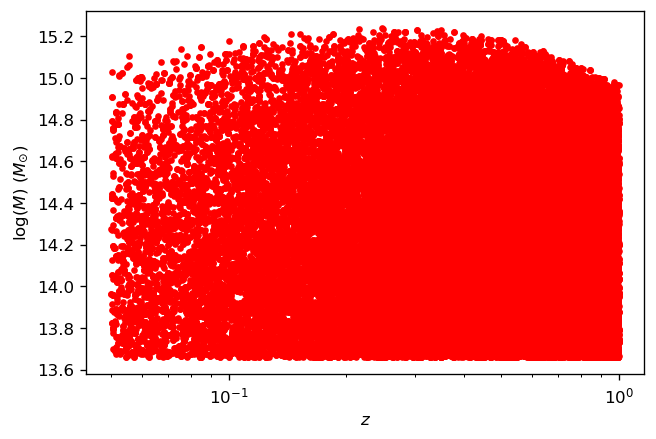

In [15]:
plt.scatter(clus_mymcmc.T[1], clus_mymcmc.T[0], marker='.', color='red')
plt.xlabel(r'$z$')
plt.ylabel(r'log($M$) ($M_{\odot}$)')
plt.xscale('log')

### Load clusters sampled from interpolated hmf mass functions and plot Mz plane
* clusters sampled with my_mcmc function but performing 2d interpolation between 5 hmf mass functions' resulting $\frac{dn}{d\,{\rm log}_{10}M}$
* code which generated this can be found [here](https://github.com/ryanduffy92/generate_cluster_sample/blob/main/sample_mass_function.py)
* primary differences: higher mass clusters sampled (can be seen below)

In [17]:
clus_interp = pd.read_csv('full_py.dat')

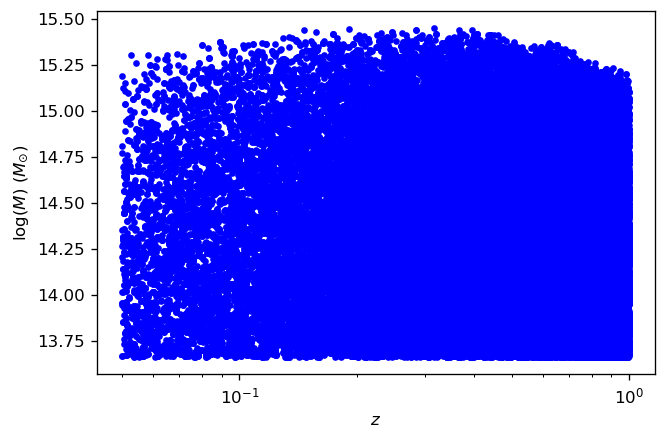

In [20]:
plt.scatter(clus_interp.z, clus_interp.logm, marker='.', color='blue')
plt.xlabel(r'$z$')
plt.ylabel(r'log($M$) ($M_{\odot}$)')
plt.xscale('log')

### Load fake NORAS sample
* 301 clusters randomly sampled from interpolated mass functions with *ROSAT* $F_{X}>3.0\times10^{-12}$ erg/s/cm2

In [4]:
noras = pd.read_csv('noras.csv')

### Calculate scaling relations

In [43]:
def calc_y(x, A, B, xnorm, ynorm):
	return ynorm * A * (x/xnorm)**B

rr = np.arange(1.5, 21.5, 0.5)
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.05612, 2.84643, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

#### With n.mixture=1

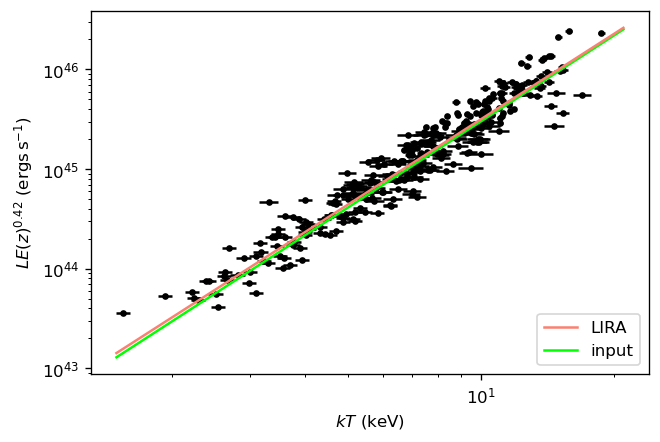

In [6]:
plt.errorbar(noras.kt_obs, noras.l_obs*noras['Ez']**0.42, xerr=noras.kt_obs_err*noras.kt_obs, yerr=noras.l_obs_err*noras.l_obs*noras['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

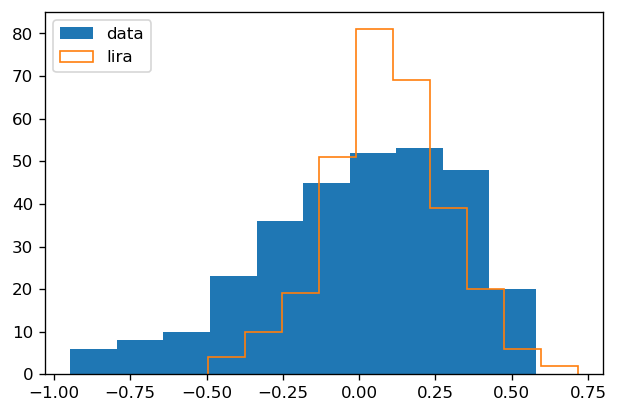

In [7]:
plt.hist(noras.logm-noras.logm.mean(), bins=10, label='data')
mu, sigma = 0.09521, 0.18493
s = np.random.normal(mu, sigma, 301)
plt.hist(s, histtype='step', bins=10, label='lira')
plt.legend(loc='upper left')

#### With n.mixture=3

In [8]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.05625, 2.849, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

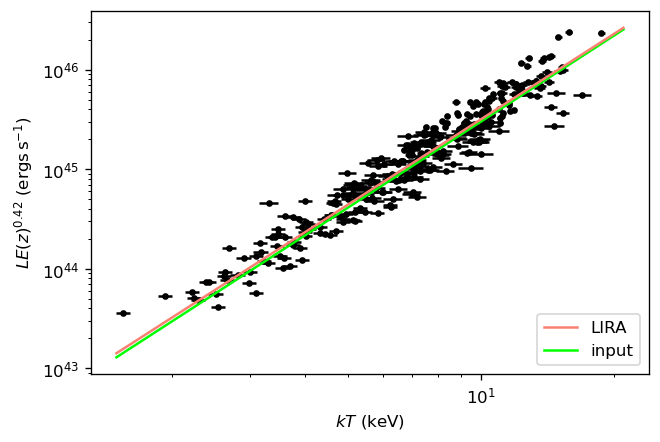

In [9]:
plt.errorbar(noras.kt_obs, noras.l_obs*noras['Ez']**0.42, xerr=noras.kt_obs_err*noras.kt_obs, yerr=noras.l_obs_err*noras.l_obs*noras['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

(array([0.38520972, 1.97538835, 0.20969389, 0.01079307, 0.11152837,
        0.53888245, 0.99450409, 0.70540406, 0.18810775, 0.02004427]),
 array([-1.03748411, -0.84291477, -0.64834544, -0.4537761 , -0.25920677,
        -0.06463743,  0.1299319 ,  0.32450124,  0.51907058,  0.71363991,
         0.90820925]),
 [<matplotlib.patches.Polygon at 0x7fd4b87f19a0>])

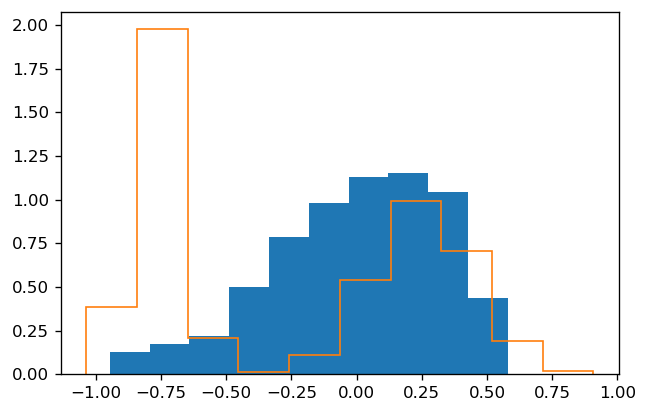

In [10]:
mu1, sigma1 = -7.591e-01, 8.046e-02
mu2, sigma2 = 2.602e-01, 1.930e-01
mu3, sigma3 = -1.473e+03, 2.353e-01
g1 = np.random.normal(mu1, sigma1, 10000)
g2 = np.random.normal(mu2, sigma2, 10000)
#g3 = np.random.normal(mu3, sigma3, 10000)
gaussians = np.concatenate([g1, g2])
plt.hist(noras.logm-noras.logm.mean(), bins=10, label='data', density=True)
plt.hist(gaussians, histtype='step', density=True)


## Effect of completeness on fits

In [11]:
cxo_obs = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
                    1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 
                    1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 
                    1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 
                    1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 
                    1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 
                    0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 
                    1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                    1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 
                    0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 
                    0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                    0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                    0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                    0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                    0.0])
noras = noras.sort_values(by='f124', ascending=False)
noras['targeted'] = cxo_obs

In [13]:
not_obs = np.where(cxo_obs == 0.0)[0]
interest = [34, 39, 45, 50, 51, 53, 81, 147, 201, 260]

In [27]:
[(sum(cxo_obs[:ii])/len(cxo_obs[:ii])) for ii in interest]

[1.0,
 0.9743589743589743,
 0.9555555555555556,
 0.94,
 0.9215686274509803,
 0.9056603773584906,
 0.8024691358024691,
 0.7006802721088435,
 0.6019900497512438,
 0.5]

### 100% complete

In [22]:
noras[:interest[0]].to_csv('noras_100pc.csv', index=False)

In [23]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.02083, 2.69229, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

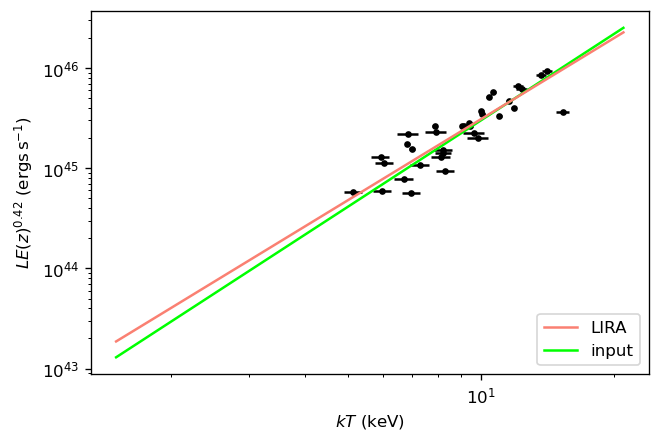

In [24]:
plt.errorbar(noras[:interest[0]].kt_obs, noras[:interest[0]].l_obs*noras[:interest[0]]['Ez']**0.42, xerr=noras[:interest[0]].kt_obs_err*noras[:interest[0]].kt_obs, yerr=noras[:interest[0]].l_obs_err*noras[:interest[0]].l_obs*noras[:interest[0]]['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

### 90% complete

In [39]:
noras[:interest[5]][noras[:interest[5]].targeted==1.0].to_csv('noras_90pc.csv', index=False)

In [45]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.05736, 2.85162, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

In [46]:
df_use = noras[:interest[5]][noras[:interest[5]].targeted == 1.0]
df_notused = noras[:interest[5]][noras[:interest[5]].targeted == 0.0]

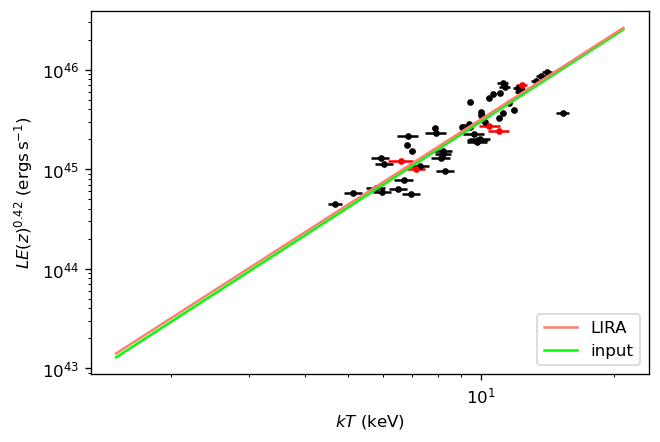

In [47]:
plt.errorbar(df_use.kt_obs, df_use.l_obs*df_use['Ez']**0.42, xerr=df_use.kt_obs_err*df_use.kt_obs, yerr=df_use.l_obs_err*df_use.l_obs*df_use['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.errorbar(df_notused.kt_obs, df_notused.l_obs*df_notused['Ez']**0.42, xerr=df_notused.kt_obs_err*df_notused.kt_obs, yerr=df_notused.l_obs_err*df_notused.l_obs*df_notused['Ez']**0.42, linestyle='', marker='.', color='red', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

### 80% complete

In [48]:
noras[:interest[6]][noras[:interest[6]].targeted==1.0].to_csv('noras_80pc.csv', index=False)

In [49]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.02755, 2.74697, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

In [50]:
df_use = noras[:interest[6]][noras[:interest[6]].targeted == 1.0]
df_notused = noras[:interest[6]][noras[:interest[6]].targeted == 0.0]

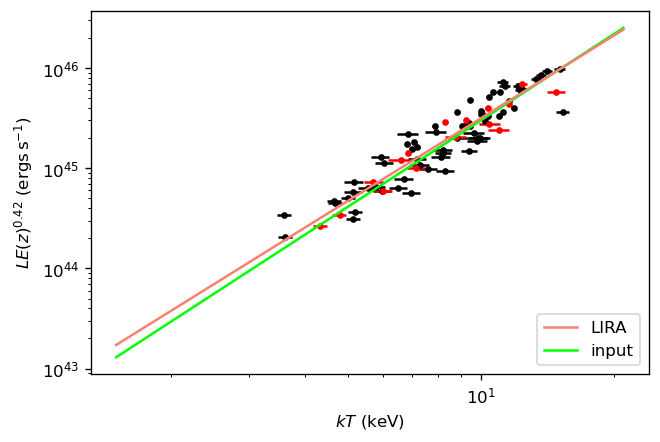

In [51]:
plt.errorbar(df_use.kt_obs, df_use.l_obs*df_use['Ez']**0.42, xerr=df_use.kt_obs_err*df_use.kt_obs, yerr=df_use.l_obs_err*df_use.l_obs*df_use['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.errorbar(df_notused.kt_obs, df_notused.l_obs*df_notused['Ez']**0.42, xerr=df_notused.kt_obs_err*df_notused.kt_obs, yerr=df_notused.l_obs_err*df_notused.l_obs*df_notused['Ez']**0.42, linestyle='', marker='.', color='red', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

### 70% complete

In [52]:
noras[:interest[7]][noras[:interest[7]].targeted==1.0].to_csv('noras_70pc.csv', index=False)

In [53]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.02026, 2.72791, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

In [54]:
df_use = noras[:interest[7]][noras[:interest[7]].targeted == 1.0]
df_notused = noras[:interest[7]][noras[:interest[7]].targeted == 0.0]

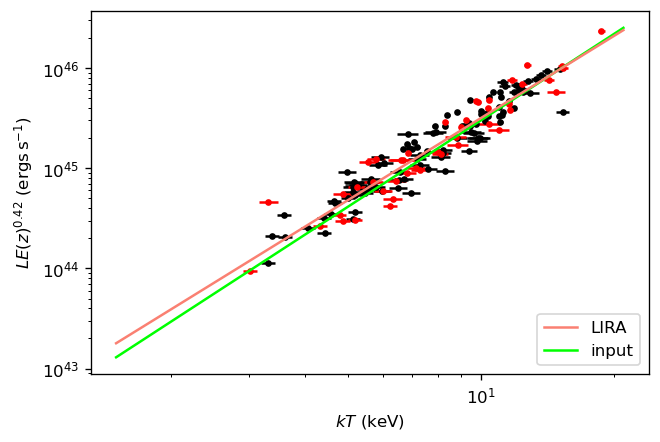

In [55]:
plt.errorbar(df_use.kt_obs, df_use.l_obs*df_use['Ez']**0.42, xerr=df_use.kt_obs_err*df_use.kt_obs, yerr=df_use.l_obs_err*df_use.l_obs*df_use['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.errorbar(df_notused.kt_obs, df_notused.l_obs*df_notused['Ez']**0.42, xerr=df_notused.kt_obs_err*df_notused.kt_obs, yerr=df_notused.l_obs_err*df_notused.l_obs*df_notused['Ez']**0.42, linestyle='', marker='.', color='red', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

### 60% complete

In [56]:
noras[:interest[8]][noras[:interest[8]].targeted==1.0].to_csv('noras_60pc.csv', index=False)

In [57]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.04617, 2.83947, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

In [58]:
df_use = noras[:interest[8]][noras[:interest[8]].targeted == 1.0]
df_notused = noras[:interest[8]][noras[:interest[8]].targeted == 0.0]

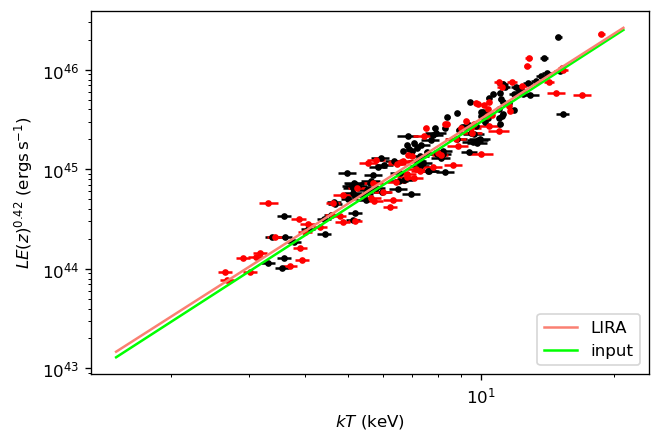

In [59]:
plt.errorbar(df_use.kt_obs, df_use.l_obs*df_use['Ez']**0.42, xerr=df_use.kt_obs_err*df_use.kt_obs, yerr=df_use.l_obs_err*df_use.l_obs*df_use['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.errorbar(df_notused.kt_obs, df_notused.l_obs*df_notused['Ez']**0.42, xerr=df_notused.kt_obs_err*df_notused.kt_obs, yerr=df_notused.l_obs_err*df_notused.l_obs*df_notused['Ez']**0.42, linestyle='', marker='.', color='red', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

### 50% complete

In [60]:
noras[:interest[9]][noras[:interest[9]].targeted==1.0].to_csv('noras_50pc.csv', index=False)

In [61]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.0432, 2.8450, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

In [62]:
df_use = noras[:interest[9]][noras[:interest[9]].targeted == 1.0]
df_notused = noras[:interest[9]][noras[:interest[9]].targeted == 0.0]

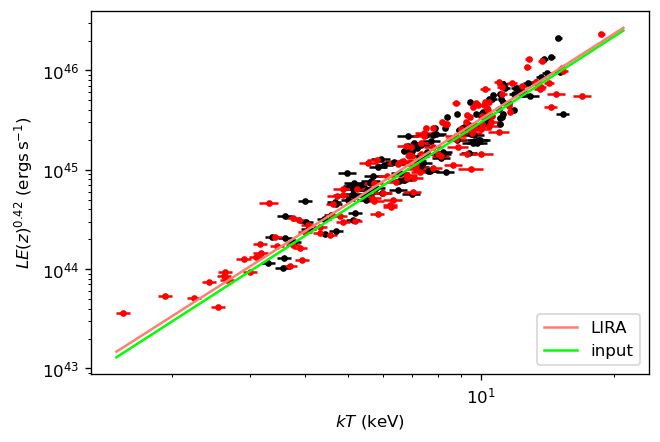

In [63]:
plt.errorbar(df_use.kt_obs, df_use.l_obs*df_use['Ez']**0.42, xerr=df_use.kt_obs_err*df_use.kt_obs, yerr=df_use.l_obs_err*df_use.l_obs*df_use['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.errorbar(df_notused.kt_obs, df_notused.l_obs*df_notused['Ez']**0.42, xerr=df_notused.kt_obs_err*df_notused.kt_obs, yerr=df_notused.l_obs_err*df_notused.l_obs*df_notused['Ez']**0.42, linestyle='', marker='.', color='red', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

### 45% complete (all available data)

In [88]:
noras[noras.targeted==1.0].to_csv('noras_45pc.csv', index=False)

In [90]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.0440, 2.8538, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

In [91]:
df_use = noras[noras.targeted == 1.0]
df_notused = noras[noras.targeted == 0.0]

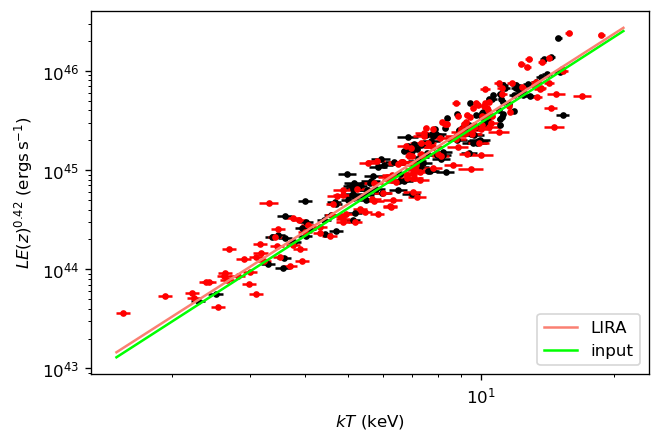

In [92]:
plt.errorbar(df_use.kt_obs, df_use.l_obs*df_use['Ez']**0.42, xerr=df_use.kt_obs_err*df_use.kt_obs, yerr=df_use.l_obs_err*df_use.l_obs*df_use['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.errorbar(df_notused.kt_obs, df_notused.l_obs*df_notused['Ez']**0.42, xerr=df_notused.kt_obs_err*df_notused.kt_obs, yerr=df_notused.l_obs_err*df_notused.l_obs*df_notused['Ez']**0.42, linestyle='', marker='.', color='red', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

### Completeness analysis

In [93]:
completeness = np.array([100, 90, 80, 70, 60, 50, 45])

norm = np.array([-0.02083, -0.05736, -0.02755, -0.02026, -0.04617, -0.0432, -0.0440])
norm_sigma = np.array([0.06456, 0.05522, 0.03479, 0.02229, 0.02044, 0.019219, 0.017187])

slope = np.array([2.69229, 2.85162, 2.74697, 2.72791, 2.83947, 2.8450, 2.8538])
slope_sigma = np.array([0.23405, 0.19316, 0.13091, 0.08641, 0.07890, 0.073912, 0.065695])

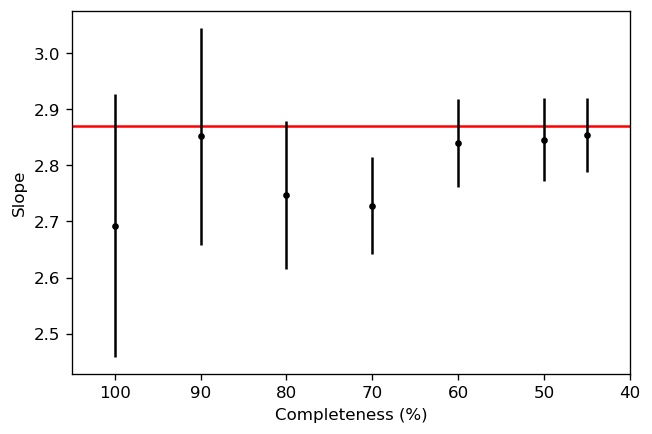

In [94]:
plt.errorbar(completeness, slope, yerr=slope_sigma, linestyle='', color='k', marker='.', zorder=20)
plt.xlim([105, 40])
plt.axhline(2.87, color='red')
plt.xlabel('Completeness (%)')
plt.ylabel('Slope')
plt.show()

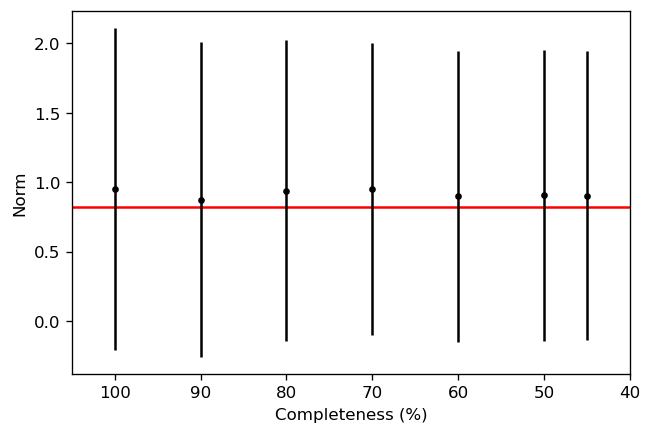

In [97]:
plt.errorbar(completeness, np.power(10, norm), yerr=np.power(10, norm_sigma), linestyle='', color='k', marker='.', zorder=20)
plt.xlim([105, 40])
plt.axhline(0.82, color='red')
plt.xlabel('Completeness (%)')
plt.ylabel('Norm')
plt.show()

* 90% completeness appears to be best fit
* More clusters also appears to get a better fit regardless of completeness
* Completeness doesn't matter? Test with 90% completeness and all data?

## Make other samples

In [145]:
# full sample generated from mass function with a selection function applied
obs = pd.read_csv('obs_py.dat')
# truncated array with only observed NORAS clusters
noras_obs = noras[noras.targeted == 1.0]
# set random state for repeatability
rs = 9

### Generate REFLEX/HECTOSPEC

In [146]:
# filter NORAS clusters from obs
obs = obs[~obs.isin(noras)].dropna()
# create REFLEX sample by drawing 349/351 clusters from obs df
reflex = obs[obs.f124 > 3.0e-12].sample(349, random_state=rs)

# create hectospec sample by pulling 35 clusters from noras_obs
hec = noras_obs[noras_obs.f124 > 5.0e-12].sample(35, random_state=rs)
# pull 2 clusters from this array to add to REFLEX df
for_ref = hec.sample(2, random_state=rs)

# add the two clusters to REFLEX df
reflex_full = pd.concat([reflex, for_ref]).reset_index(drop=True).sort_values(by='f124', ascending=False)
cxo_obs = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0])
reflex_full['targeted'] = cxo_obs
# truncated array with only observed REFLEX clusters
reflex_obs = reflex_full[reflex_full.targeted == 1.0]

# filter REFLEX clusters from obs df
obs = obs[~obs.isin(reflex_full)].dropna()

# hectospec other 22 clusters
hec2 = obs[obs.f124 > 5.0e-12].sample(22, random_state=rs)
# concatenate hectospec clusters
hec_full = pd.concat([hec, hec2]).reset_index(drop=True)

# filter these from obs df
obs = obs[~obs.isin(hec_full)].dropna()

### Generate MACS sample

In [147]:
# start macs by pulling 5 cxo observed noras & reflex clusters above 2.0e-12 erg/s/cm2 in appropriate z range
macs = noras_obs[(noras_obs.f124 > 2.0e-12) & (noras_obs.z > 0.3) & (noras_obs.z < 0.7)].sample(5, random_state=rs)
macs2 = reflex_obs[(reflex_obs.f124 > 2.0e-12) & (reflex_obs.z > 0.3) & (reflex_obs.z < 0.7)].sample(5, random_state=rs)

# macs other 36 clusters
macs3 = obs[(obs.f124 > 2.0e-12) & (obs.z > 0.3) & (obs.z < 0.7)].sample(36, random_state=rs)

# concatenate macs clusters into single df
macs_full = pd.concat([macs, macs2, macs3]).reset_index(drop=True)

# filter these from obs df
obs = obs[~obs.isin(macs_full)].dropna()

### Generate 400d sample

In [148]:
# make 400d: NOTE THIS MAY NOT MIMIC EXACTLY IN FLUX SPACE
# 3 clusters from NORAS
_400d1 = noras_obs[~noras_obs.isin(macs)].dropna().sample(3, random_state=rs)
_400d1['other_samples'] = np.array([1.0 for ii in range(len(_400d1))])
# 1 cluster from REFLEX
_400d2 = reflex_obs[~reflex_obs.isin(macs2)].sample(1, random_state=rs)
_400d2['other_samples'] = 1.0

# high z sample
_400d3 = obs[(obs.f124 > 1.4e-13) & (obs.z > 0.35)].sample(45, random_state=rs)
# filter these from obs df
obs = obs[~obs.isin(_400d3)].dropna()
_400d3['other_samples'] = np.array([0.0 for ii in range(len(_400d3))])

# group sample, pars from Zou+16
_400d4 = obs[(obs.f124 > 5.0e-13) & (obs.z < 0.15) & (obs.kt_obs < 3.89)].sample(25, random_state=rs) 
#_400d4 = obs[(obs.f124 > 5.0e-13) & (obs.z < 0.15)].sample(25, random_state=rs) 
_400d4['other_samples'] = np.array([0.0 for ii in range(len(_400d4))])
# filter these from obs df
obs = obs[~obs.isin(_400d4)].dropna()

# inbetween sample (observed)
_400d5 = obs[obs.f124 > 1.4e-13].sample(13, random_state=rs)
# filter these from obs df
obs = obs[~obs.isin(_400d5)]
_400d5['other_samples'] = np.array([0.0 for ii in range(len(_400d5))])

# concatenate observed sample and add targeted column
dflist = [_400d1, _400d2, _400d3, _400d4, _400d5]
_400d_obs = pd.concat(dflist).reset_index(drop=True)
_400d_obs['targeted'] = np.array([1.0 for ii in range(len(_400d_obs))])

# unobserved sample
_400d_nobs = obs[obs.f124 > 1.4e-13].sample(138, random_state=rs)
_400d_nobs['other_samples'] = np.array([0.0 for ii in range(len(_400d_nobs))])
_400d_nobs['targeted'] = np.array([0.0 for ii in range(len(_400d_nobs))])
_400d_full = pd.concat([_400d_obs, _400d_nobs]).reset_index(drop=True)

# filter these from obs df
obs = obs[~obs.isin(_400d_full)]

### Generate WARPS (probably not getting used)

In [149]:
#make warps
warps1 = _400d_obs[_400d_obs.f124 > 3.5e-14].sample(7, random_state=rs)
warps1['other_samples'] = np.array([1.0 for ii in range(len(warps1))])
warps2 = obs[obs.f124 > 3.5e-14].sample(114, random_state=rs)
warps2['other_samples'] = np.array([0.0 for ii in range(len(warps2))])
warps_full = pd.concat([warps1, warps2]).reset_index(drop=True)
cxo_obs = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0])
warps_full['targeted'] = cxo_obs
warps_obs = warps_full[warps_full.targeted == 1.0]

#### Add other sample columns

In [150]:
#rename targeted column to noras_clus in macs and hec and replace NaNs with 0
macs_full = macs_full.rename(columns={'targeted': 'other_samples'})
macs_full.other_samples = macs_full.other_samples.replace(np.nan, 0)

hec_full = hec_full.rename(columns={'targeted': 'other_samples'})
hec_full.other_samples = hec_full.other_samples.replace(np.nan, 0)

#### calculate limiting luminosities

In [41]:
def calc_lum(flux, z, cosmo):
    dl = cosmo.luminosity_distance(z).value * 3.086e24
    return flux*4*np.pi*dl**2

In [152]:
#calculate limiting luminosity at each redshift
noras['y_thresh'] = [calc_lum(3.0e-12, ii, cosmo) for ii in noras.z]
macs_full['y_thresh'] = [calc_lum(2.0e-12, ii, cosmo) for ii in macs_full.z]
hec_full['y_thresh'] = [calc_lum(5.0e-12, ii, cosmo) for ii in hec_full.z]
reflex_full['y_thresh'] = [calc_lum(3.0e-12, ii, cosmo) for ii in reflex_full.z]
_400d_full['y_thresh'] = [calc_lum(1.4e-13, ii, cosmo) for ii in _400d_full.z]
warps_full['y_thresh'] = [calc_lum(3.5e-14, ii, cosmo) for ii in warps_full.z]

#### save dfs

In [153]:
macs_full.to_csv('macs.csv', index=False)
hec_full.to_csv('hec.csv', index=False)
reflex_full.to_csv('reflex.csv', index=False)
_400d_full.to_csv('400d.csv', index=False)
warps_full.to_csv('warps.csv', index=False)

#### Make df of every cluster

In [173]:
noras_inc = noras[noras.targeted == 1]
reflex_inc = noras[noras.targeted == 1]
macs_inc = macs_full[(macs_full.other_samples == 0.0)]
hec_inc = hec_full[(hec_full.other_samples == 0.0)]
_400d_inc = _400d_full[(_400d_full.targeted == 1) & (_400d_full.other_samples == 0.0)]

dflist = [noras_inc, reflex_inc, macs_inc, hec_inc, _400d_inc]
inc = pd.concat(dflist).reset_index(drop=True)

inc.to_csv('all_fake_for_lira.csv')


### All Clusters

In [179]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.04565, 2.86007, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

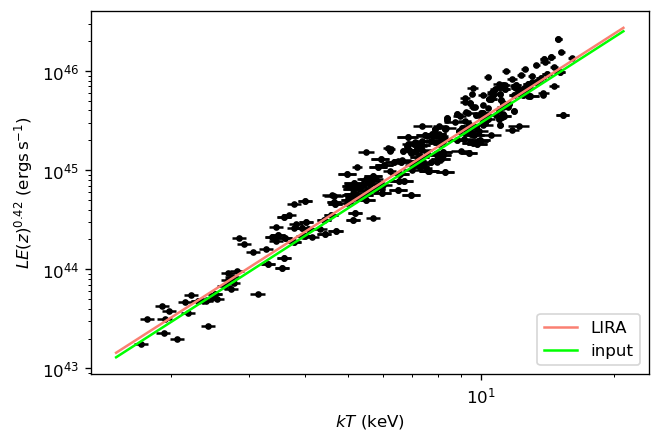

In [184]:
plt.errorbar(inc.kt_obs, inc.l_obs*inc['Ez']**0.42, xerr=inc.kt_obs_err*inc.kt_obs, yerr=inc.l_obs_err*inc.l_obs*inc['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
#plt.errorbar(df_notused.kt_obs, df_notused.l_obs*df_notused['Ez']**0.42, xerr=df_notused.kt_obs_err*df_notused.kt_obs, yerr=df_notused.l_obs_err*df_notused.l_obs*df_notused['Ez']**0.42, linestyle='', marker='.', color='red', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')

## Testing on real data 

In [12]:
data_dir = '/Users/rd268277/analysis/charms/scaling/data/'
noras = pd.read_csv(f'{data_dir}/noras_lt.out')
noras['sample'] = 'noras'
reflex = pd.read_csv(f'{data_dir}/reflex_lt.out')
reflex['sample'] = 'reflex'
macs = pd.read_csv(f'{data_dir}/macs_lt.out')
macs['sample'] = 'macs'
hec = pd.read_csv(f'{data_dir}/hectospec_lt.out')
hec['sample'] = 'hec'
_400d = pd.read_csv(f'{data_dir}/400d_lt.out')
_400d['sample'] = '400d'

In [13]:
noras = noras.dropna()
reflex = reflex.dropna()
macs = macs.dropna()
hec = hec.dropna()
_400d = _400d.dropna()

In [14]:
#calculate limiting luminosity at each redshift
noras['y_thresh'] = [calc_lum(3.0e-12, ii, cosmo) for ii in noras.z]
macs['y_thresh'] = [calc_lum(2.0e-12, ii, cosmo) for ii in macs.z]
hec['y_thresh'] = [calc_lum(5.0e-12, ii, cosmo) for ii in hec.z]
reflex['y_thresh'] = [calc_lum(3.0e-12, ii, cosmo) for ii in reflex.z]
_400d['y_thresh'] = [calc_lum(1.4e-13, ii, cosmo) for ii in _400d.z]

In [36]:
dflist = [noras, reflex, macs, hec, _400d]
for_fit = pd.concat(dflist).reset_index(drop=True)
for_fit = for_fit[for_fit.l > for_fit.y_thresh]
for_fit = for_fit.drop_duplicates(subset=['root'])

In [39]:
for_fit.to_csv(f'{data_dir}/real_for_fit.csv', index=False)

In [47]:
def Ez(z, Om, Ol):
	return np.sqrt(Om*(1+z)**3 + Ol)

In [48]:
for_fit['Ez'] = Ez(for_fit.z, 0.3, 0.7)

In [57]:
# scaling relation from LIRA
rr = np.linspace(0.8, 25.0, 100)
ys = calc_y(rr, 10**-0.31590, 2.54345, 5.0, 5.0e44)

Text(0, 0.5, '$LE(z)^{0.42}$ (ergs$\\,$s$^{-1}$)')

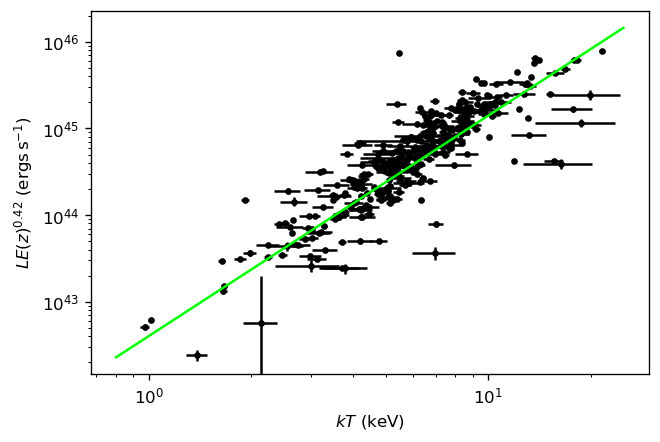

In [58]:
plt.errorbar(for_fit.kt, for_fit.l*for_fit['Ez']**0.42, xerr=for_fit.kt_err*for_fit.kt, yerr=for_fit.l_err*for_fit.l*for_fit['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.plot(rr, ys, color='lime', zorder=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')

In [59]:
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.33043, 2.51181, 5.0, 5.0e44)

Text(0, 0.5, '$LE(z)$ (ergs$\\,$s$^{-1}$)')

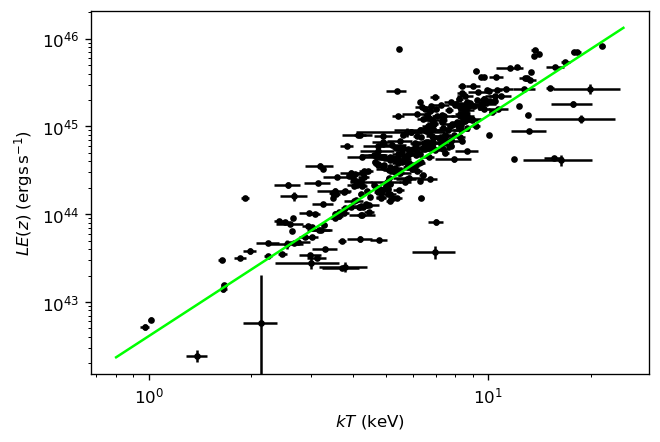

In [60]:
plt.errorbar(for_fit.kt, for_fit.l*for_fit['Ez']**1.0, xerr=for_fit.kt_err*for_fit.kt, yerr=for_fit.l_err*for_fit.l*for_fit['Ez']**1.0, linestyle='', marker='.', color='k', zorder=0)
plt.plot(rr, ys, color='lime', zorder=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)$ (ergs$\,$s$^{-1}$)')